<a href="https://colab.research.google.com/github/saquibali7/VideoClassification/blob/main/3dCNN_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [3]:
data_path = '/content/drive/MyDrive/Set1'
data = os.listdir(data_path)
print(len(data))

111


In [4]:
def return_frames(idx):
  frames = list()
  cap = cv2.VideoCapture(os.path.join(data_path,data[idx]))
  while(cap.isOpened()):
    ret, frame = cap.read()
    try:
      img = cv2.resize(frame, (256,256))
      frames.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  cap.release()
  cv2.destroyAllWindows() 
  frames = np.array(frames)
  return frames

In [5]:
df = pd.read_excel('/content/drive/MyDrive/ClassLabels.xlsx')
df.head()

,Video_Id,Outcome
0,D2014.09.23_S0180_I4274,Freeze
1,D2014.09.23_S0180_I4277,Freeze
2,D2014.11.28_S0311_I4262,Transfer
3,D2015.01.22_S0337_I4261,Transfer
4,D2015.01.22_S0337_I4264,Freeze


In [6]:
print(df['Outcome'].values)

['Freeze' 'Freeze' 'Transfer' 'Transfer' 'Freeze' 'Freeze' 'Freeze'
 'Freeze' 'Freeze' 'Freeze' 'Transfer' 'Transfer' 'Freeze' 'Freeze'
 'Transfer' 'Freeze' 'Freeze' 'Transfer' 'Freeze' 'Avoid' 'Transfer'
 'Avoid' 'Avoid' 'Freeze' 'Freeze' 'Avoid' 'Transfer' 'Avoid' 'Avoid'
 'Freeze' 'Freeze' 'Freeze' 'Transfer' 'Avoid' 'Transfer' 'Freeze' 'Avoid'
 'Freeze' 'Avoid' 'Freeze' 'Transfer' 'Avoid' 'Avoid' 'Transfer' 'Freeze'
 'Transfer' 'Avoid' 'Freeze' 'Avoid' 'Freeze' 'Transfer' 'Freeze' 'Freeze'
 'Freeze' 'Transfer' 'Avoid' 'Freeze' 'Freeze' 'Freeze' 'Freeze' 'Freeze'
 'Avoid' 'Freeze' 'Transfer' 'Avoid' 'Transfer' 'Avoid' 'Freeze' 'Avoid'
 'Avoid' 'Transfer' 'Transfer' 'Freeze' 'Avoid' 'Avoid' 'Transfer' 'Avoid'
 'Transfer' 'Freeze' 'Freeze' 'Avoid' 'Freeze' 'Freeze' 'Avoid' 'Transfer'
 'Transfer' 'Avoid' 'Freeze' 'Transfer' 'Freeze' 'Transfer' 'Freeze'
 'Freeze' 'Freeze' 'Avoid' 'Transfer' 'Transfer' 'Avoid' 'Avoid' 'Freeze'
 'Transfer' 'Transfer' 'Freeze' 'Avoid' 'Transfer' 'Transfer'

In [7]:
import random
classes = ['Avoid', 'Transfer','Freeze']
idx = random.randint(0,len(data))
video_id = data[idx][0:len(data[idx])-4]
row_id = df.index[df['Video_Id']==video_id]
class_name = df['Outcome'][row_id].item()
print(class_name,classes.index(class_name))

Transfer 1


## Model Architecture

In [8]:
!pip install remotezip tqdm opencv-python einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import tqdm
import random
import pathlib
import itertools
import collections

import einops
import remotezip as rz
import seaborn as sns

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential

In [10]:
HEIGHT = 256
WIDTH = 256

In [11]:
class conv_blocks(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.layer1 = layers.Conv3D(filters=filters,kernel_size=(1, kernel_size[1], kernel_size[2]),
                                padding=padding)
    self.layer2 = layers.Conv3D(filters=filters, kernel_size=(kernel_size[0], 1, 1),
                                padding=padding)
    
  def call(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

In [12]:
class Project(keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.layer1 = layers.Dense(units)
    self.layer2 = layers.LayerNormalization()

  def call(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

In [13]:
class ResidualMain(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.layer1 = conv_blocks(filters=filters,kernel_size=kernel_size,padding='same')
    self.layer2 = layers.LayerNormalization()
    self.layer3 = layers.ReLU()
    self.layer4 = conv_blocks(filters=filters, kernel_size=kernel_size,padding='same')
    self.layer5 = layers.LayerNormalization()


  def call(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    return x

In [14]:
def add_residual_block(input, filters, kernel_size):
  out = ResidualMain(filters, kernel_size)(input)

  res = input
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [15]:

class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [20]:
input_shape = (None, 25, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input



x = conv_blocks(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(3)(x)
x = layers.Softmax()(x)

model = keras.Model(input, x)
idx = random.randint(0,len(data))
frames = return_frames(idx)
model.build(frames[0:25])



In [21]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 256, 25  0           []                               
                                6, 3)]                                                            
                                                                                                  
 conv_blocks_9 (conv_blocks)    (None, 25, 256, 256  3152        ['input_2[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 25, 256, 256  64         ['conv_blocks_9[0][0]']          
 rmalization)                   , 16)                                                       

In [23]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(df["Outcome"]))
print(label_processor.get_vocabulary())


['Avoid', 'Freeze', 'Transfer']


## Testing

In [24]:
flip = tf.keras.layers.RandomFlip("horizontal_and_vertical") # or "horizontal", "vertical"
rotate = tf.keras.layers.RandomRotation(0.2)
translation = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)

In [25]:
labels = list()
train_x = list()
for idx in range(len(data)):
  frames = return_frames(idx)
  temp1 = []
  temp2 = []
  for i in range(25):
    temp1.append(flip(frames[i]));
  for i in range(25):
    temp2.append(flip(frames[i+25]))  
  train_x.append(frames[0:25])
  train_x.append(temp1)
  train_x.append(frames[25:50])
  train_x.append(temp2)


  video_id = data[idx][0:len(data[idx])-4]
  row_id = df.index[df['Video_Id']==video_id]
  class_name = df['Outcome'][row_id].item()
  for i in range(4):
    labels.append(class_name)  

In [26]:
train_x = np.array(train_x)
train_x.shape

(444, 25, 256, 256, 3)

In [27]:
train_x = (train_x/255.0).astype(np.float16)

In [28]:
print(len(train_x))
print(len(labels))
labels = np.array(labels)
labels = label_processor(labels[..., None]).numpy()

444
444


In [29]:
temp = list(zip(train_x, labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
res1 , res2 = list(res1), list(res2)
train_x , train_y = np.array(res1), np.array(res2)


In [30]:
print(train_y.shape,train_x.shape)

(444, 1) (444, 25, 256, 256, 3)


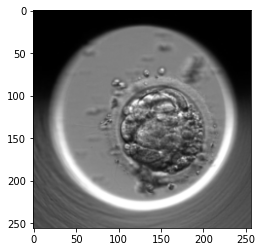

In [31]:
idx = random.randint(0,len(train_x))
idx1 = random.randint(0,len(train_x[idx]))
plt.imshow(train_x[idx][idx1].astype(np.float32))

In [32]:
history = model.fit(train_x,train_y, batch_size=4, epochs = 10, validation_split=0.2)

Epoch 1/10
89/89 [==============================] - 99s 942ms/step - loss: 1.2844 - accuracy: 0.3775 - val_loss: 1.4058 - val_accuracy: 0.3820
Epoch 2/10
89/89 [==============================] - 75s 849ms/step - loss: 1.1283 - accuracy: 0.4225 - val_loss: 1.1555 - val_accuracy: 0.3708
Epoch 3/10
89/89 [==============================] - 75s 849ms/step - loss: 1.0956 - accuracy: 0.4338 - val_loss: 1.1568 - val_accuracy: 0.2809
Epoch 4/10
89/89 [==============================] - 75s 849ms/step - loss: 1.0670 - accuracy: 0.4507 - val_loss: 1.1466 - val_accuracy: 0.4045
Epoch 5/10
89/89 [==============================] - 75s 849ms/step - loss: 1.0970 - accuracy: 0.4535 - val_loss: 1.0595 - val_accuracy: 0.3933
Epoch 6/10
89/89 [==============================] - 75s 849ms/step - loss: 1.0850 - accuracy: 0.4451 - val_loss: 1.0661 - val_accuracy: 0.3483
Epoch 7/10
89/89 [==============================] - 75s 848ms/step - loss: 1.0395 - accuracy: 0.4732 - val_loss: 1.0039 - val_accuracy: 0.5506

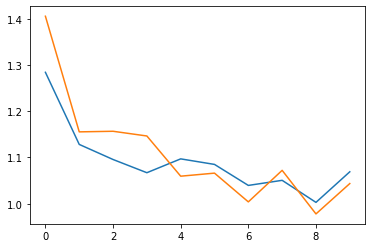

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

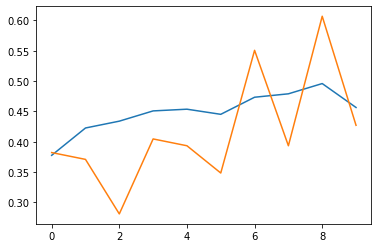

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [35]:
!mkdir '/content/drive/MyDrive/VideoClassification'

In [36]:
model.save('/content/drive/MyDrive/VideoClassification')